# Instalando PyGMTSAR no Colab


In [ ]:
import platform, sys, os

In [ ]:
if 'google.colab' in sys.modules:
    count = !ls /usr/local | grep GMTSAR | wc -l
    if count == ['0']:
        !apt install -y csh autoconf gfortran \
            libtiff5-dev libhdf5-dev liblapack-dev libgmt-dev gmt-dcw gmt-gshhg gmt > /dev/null
        !apt install gcc-9
        !update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 10
        !update-alternatives --config gcc
        !gcc --version
        !rm -fr /usr/local/GMTSAR
        !cd /usr/local && git clone --branch master https://github.com/gmtsar/gmtsar GMTSAR > /dev/null
        !cd /usr/local/GMTSAR && git checkout e98ebc0f4164939a4780b1534bac186924d7c998 > /dev/null
        !cd /usr/local/GMTSAR && autoconf > /dev/null
        !cd /usr/local/GMTSAR && ./configure --with-orbits-dir=/tmp > /dev/null
        !cd /usr/local/GMTSAR && make 1>/dev/null 2>/dev/null
        !cd /usr/local/GMTSAR && make install >/dev/null
        !echo '#!/bin/sh' > /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !echo echo /usr/local/GMTSAR/share/gmtsar >> /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !chmod a+x /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !/usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !/usr/local/GMTSAR/bin/make_s1a_tops



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-9 gcc-9-base libasan5 libgcc-9-dev
Suggested packages:
  gcc-9-locales gcc-9-multilib gcc-9-doc
The following NEW packages will be installed:
  cpp-9 gcc-9 gcc-9-base libasan5 libgcc-9-dev
0 upgraded, 5 newly installed, 0 to remove and 19 not upgraded.
Need to get 27.5 MB of archives.
After this operation, 89.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 gcc-9-base amd64 9.5.0-1ubuntu1~22.04 [19.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 cpp-9 amd64 9.5.0-1ubuntu1~22.04 [10.6 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libasan5 amd64 9.5.0-1ubuntu1~22.04 [3,140 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libgcc-9-dev amd64 9.5.0-1ubuntu1~22.04 [2,520 kB]
Get:5 http://archive.ubunt

In [ ]:
# Configurando variável de ambiente
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/local/GMTSAR/bin/


In [ ]:
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install matplotlib seaborn geoviews hvplot datashader bokeh > /dev/null

In [ ]:
!{sys.executable} -m pip install pygmtsar==2023.2.21 'dask[array]==2022.12.1'> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geoviews 1.11.0 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.
panel 1.3.0 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.


# Bibliotecas e parâmetros de busca

In [ ]:
# Bibliotecas
import xarray as xr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from dask.distributed import Client
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
from pygmtsar import SBAS
from pygmtsar import tqdm_dask
import dask

In [ ]:
# Parâmetros
WORKDIR      = 'insar'
DATADIR      = 'corr'
DEMFILE      = None
POLARIZATION = 'VV'
RESOLUTION   = 90
SCENES = [
'S1A_IW_SLC__1SDV_20220907T084533_20220907T084600_044896_055CDB_55D7',
'S1A_IW_SLC__1SDV_20220814T084532_20220814T084559_044546_055112_8E8D'
]
ORBIT='D'
SUBSWATH=2

# Baixando cenas do ASF

In [ ]:
if 'google.colab' in sys.modules:
    import time
    import getpass
    print ('Data directory does not exists or it is empty, download the datasets')
    time.sleep(1)
    username = getpass.getpass('Please enter your ASF username and press Enter key:')
    password = getpass.getpass('Please enter your ASF password and press Enter key:')
    for scene in SCENES:
        url = f'https://datapool.asf.alaska.edu/SLC/S{scene[2:3]}/{scene}.zip'
        !wget --user={username} --password={password} -qc {url}
        !unzip -j -n {scene}.zip '*.SAFE/*/s1?-iw?-slc-{POLARIZATION.lower()}-*' -d {DATADIR}
    !rm -rf *.zip

Data directory does not exists or it is empty, download the datasets
Archive:  S1A_IW_SLC__1SDV_20220907T084533_20220907T084600_044896_055CDB_55D7.zip
  inflating: corr/s1a-iw1-slc-vv-20220907t084533-20220907t084558-044896-055cdb-004.xml  
  inflating: corr/s1a-iw2-slc-vv-20220907t084534-20220907t084559-044896-055cdb-005.xml  
  inflating: corr/s1a-iw3-slc-vv-20220907t084535-20220907t084600-044896-055cdb-006.xml  
  inflating: corr/s1a-iw1-slc-vv-20220907t084533-20220907t084558-044896-055cdb-004.tiff  
  inflating: corr/s1a-iw2-slc-vv-20220907t084534-20220907t084559-044896-055cdb-005.tiff  
  inflating: corr/s1a-iw3-slc-vv-20220907t084535-20220907t084600-044896-055cdb-006.tiff  
Archive:  S1A_IW_SLC__1SDV_20220814T084532_20220814T084559_044546_055112_8E8D.zip
  inflating: corr/s1a-iw1-slc-vv-20220814t084532-20220814t084557-044546-055112-004.xml  
  inflating: corr/s1a-iw2-slc-vv-20220814t084532-20220814t084558-044546-055112-005.xml  
  inflating: corr/s1a-iw3-slc-vv-20220814t084533-202

# Script

In [ ]:
# Instanciando DASK
if 'client' in globals():
    client.close()
client = Client()
client

In [ ]:
# Lendo imagens e parâmetros no PyGMTSAR
sbas = SBAS(DATADIR, DEMFILE, basedir=WORKDIR,
    filter_orbit=ORBIT,
    filter_subswath=SUBSWATH,
    filter_polarization=POLARIZATION)

sbas.to_dataframe()

In [ ]:
# Baixando arquivos de órbita
# No momento, não está sendo possível baixar diretamente,
#por isso está sendo disponibilizado login para ir direto no site do copernicus
username = 'sifts0_spangle@icloud.com'
password = 'cnjwdchuwe&e9d0We9'
!echo "machine dataspace.copernicus.eu login {username} password {password}" > ~/.netrc
!chmod 600 ~/.netrc
sbas.download_orbits()

In [ ]:
# Reframe e download de DEM
sbas.reframe_parallel()
sbas.download_dem(backend='GMT', resolution_meters=RESOLUTION)

In [ ]:
# Visualização do subswath escolhido
plt.figure(figsize=(12,4), dpi=150)
dem = sbas.get_dem()
dem[::4,::4].plot.imshow(cmap='gray', vmin=0)
sbas.to_dataframe().plot(color='orange', alpha=0.2, ax=plt.gca())
plt.title('Subswath - 2', fontsize=18)
plt.show()

In [ ]:
# Stack
sbas.stack_parallel()
sbas.topo_ra_parallel()

In [ ]:
# Verificando data das cenas
pairs = [sbas.to_dataframe().index.unique()]
pairs

In [ ]:
# Calculando interferograma e correlação
decimator = sbas.pixel_decimator(resolution_meters=RESOLUTION)
sbas.intf_parallel(pairs, func=decimator, n_jobs=1)
sbas.merge_parallel(pairs)
sbas.geocode_parallel(pairs)
phasefilt_ra = sbas.open_grids(pairs, 'phasefilt')[0]
corr_ra = sbas.open_grids(pairs, 'corr')[0]
phasefilt = sbas.open_grids(pairs, 'phasefilt', geocode=True, crop_valid=True)[0]
corr = sbas.open_grids(pairs, 'corr', geocode=True, crop_valid=True)[0]

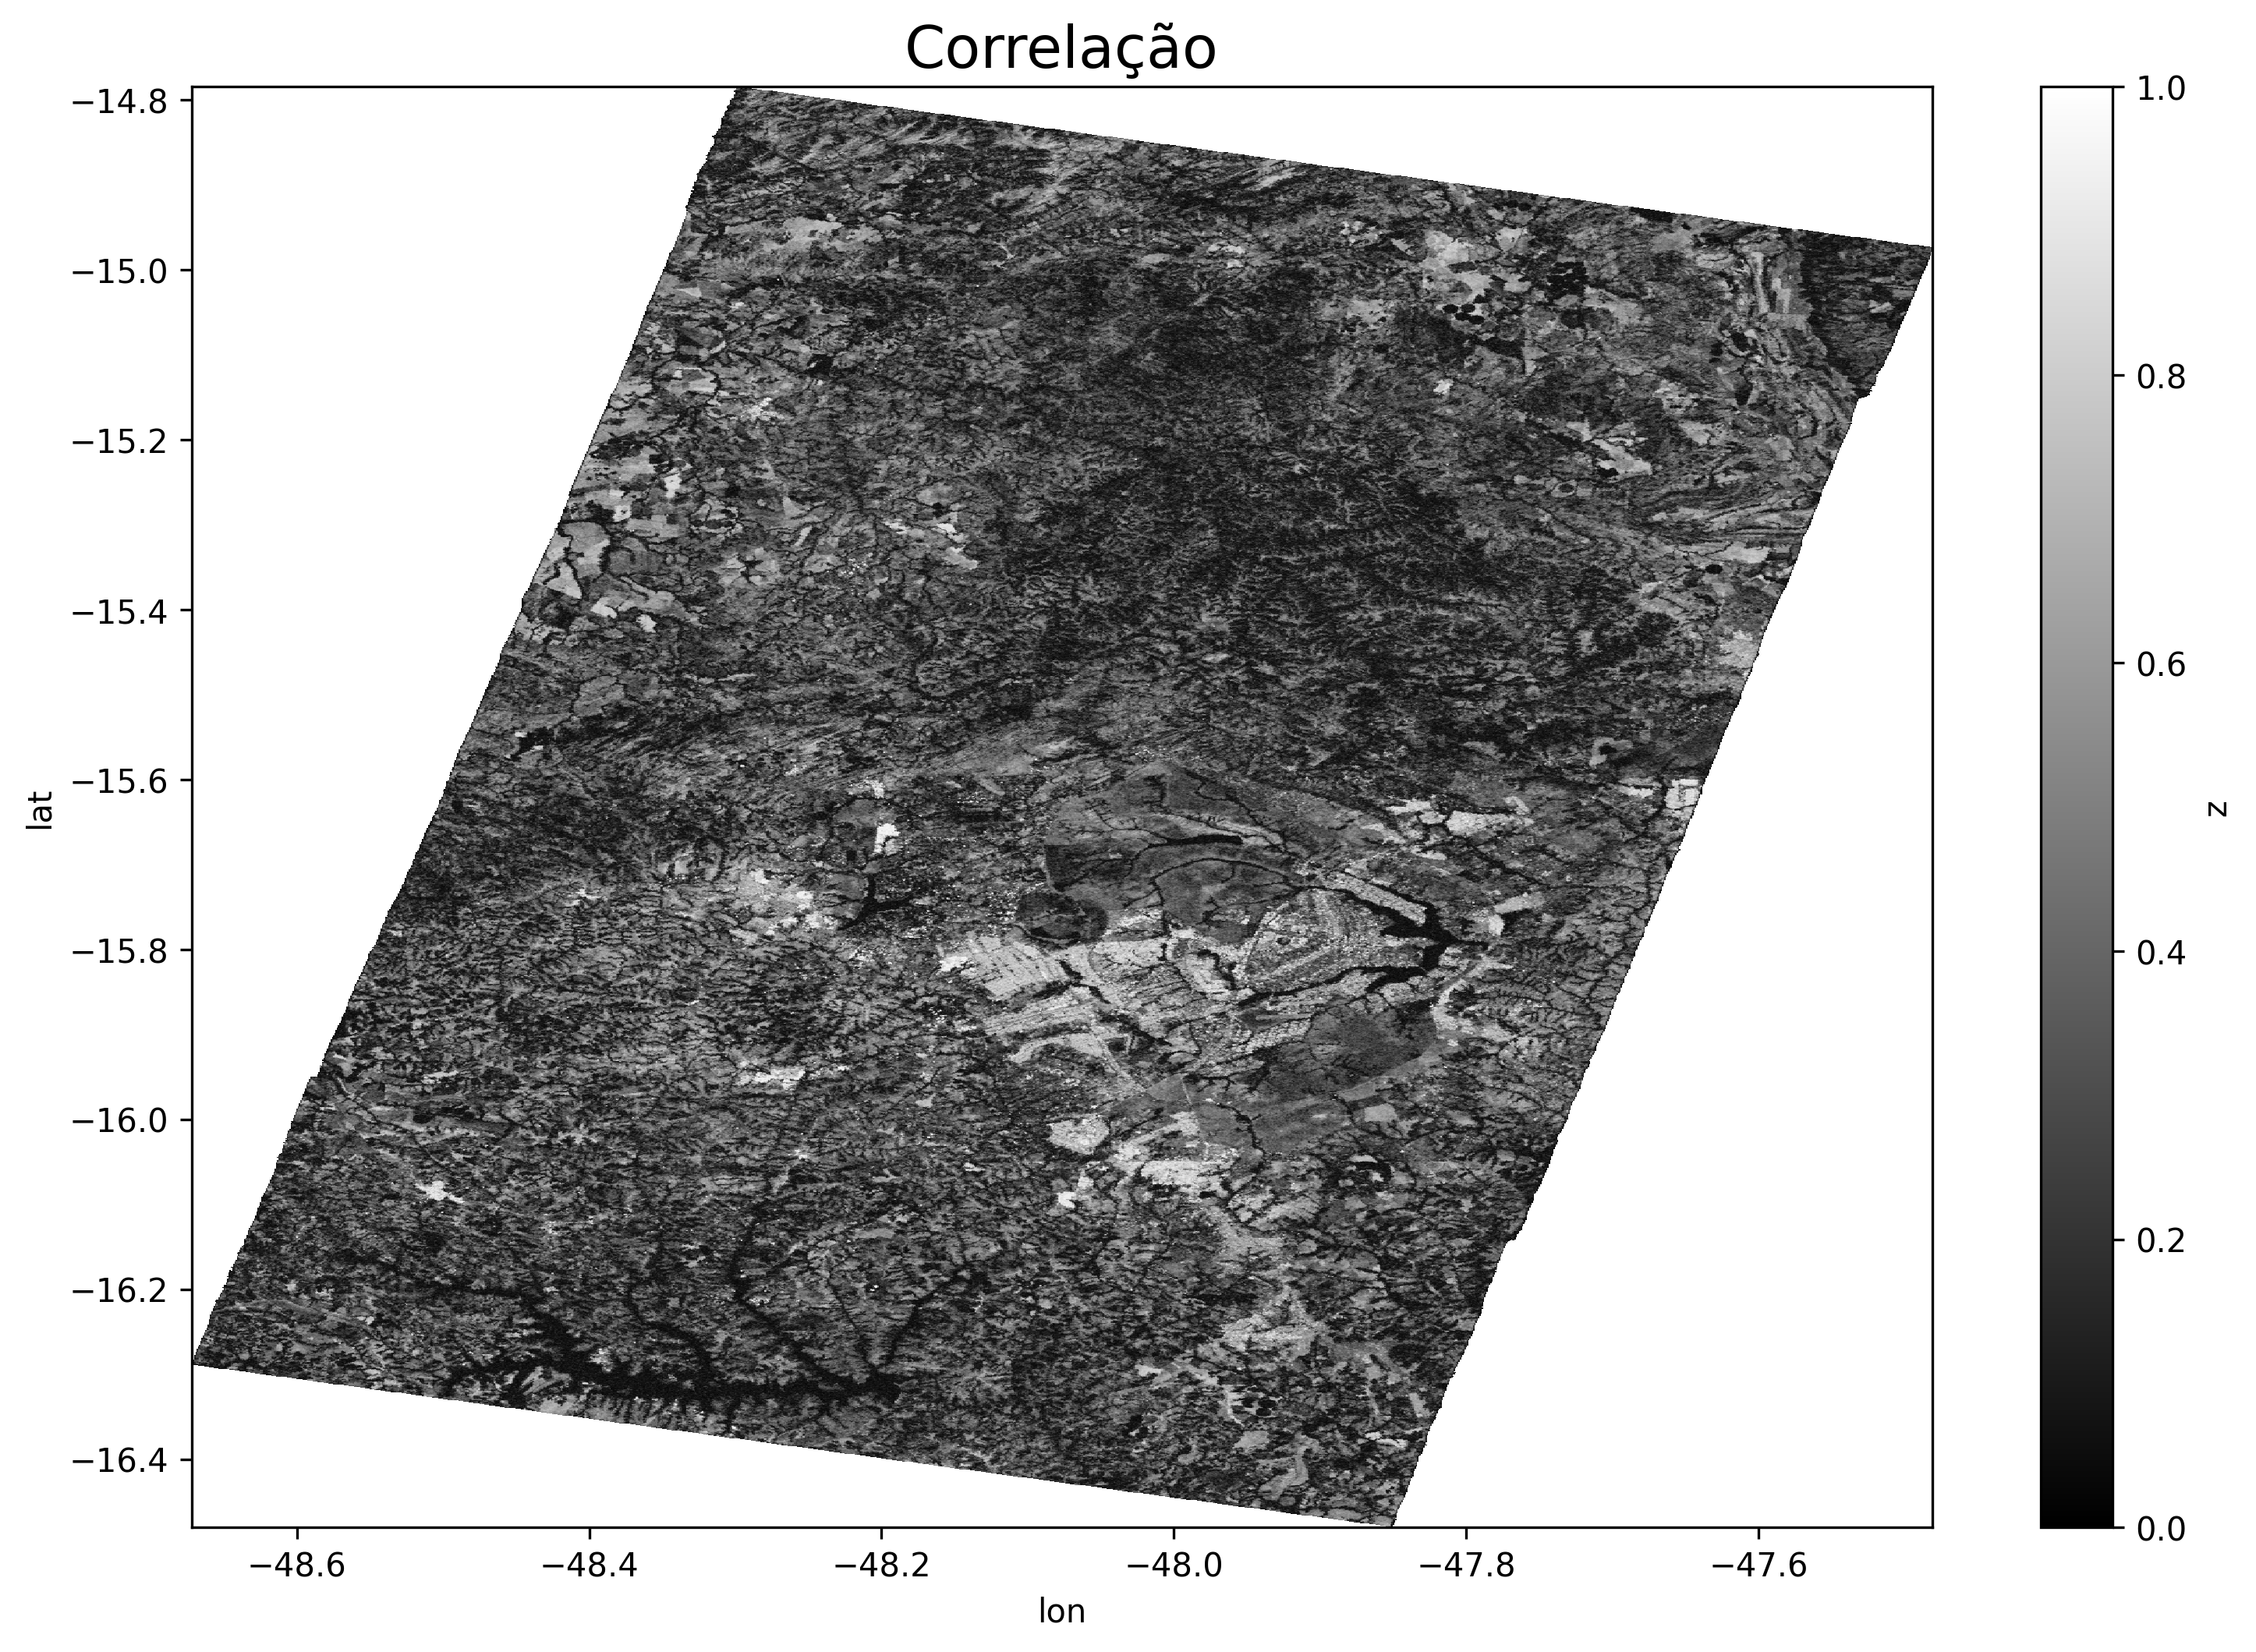

In [ ]:
# Visualizando correlação
plt.figure(figsize=(12,8), dpi=300)
corr.plot.imshow(vmin=-0, vmax=1, cmap='gray')
plt.title('Correlação', fontsize=18)
plt.show()